In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras.models import load_model
import sys, os, pickle, cv2, imageio
sys.path.append("/home/esteban/Desktop/END2END/ddsm_train")

from os import path

# FUNCION READ RESIZE

In [2]:
def read_resize_img(fname, target_size=None, target_height=None, target_scale=None, gs_255=False, rescale_factor=None):
    """Read an image (.png, .jpg, .dcm) and resize it to target size."""
    if target_size is None and target_height is None:
        raise Exception('One of [taget_size, target_height] must not be None')
    if path.splitext(fname)[1] == '.dcm':
        img = dicom.read_file(fname).pixel_array
    else:
        if gs_255:
            img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
        else:
            img = cv2.imread(fname, cv2.IMREAD_UNCHANGED)
    if target_height is not None:
        target_width = int(float(target_height) / img.shape[0] * img.shape[1])
    else:
        target_height, target_width = target_size
    if (target_height, target_width) != img.shape:
        img = cv2.resize(img, dsize=(target_width, target_height), interpolation=cv2.INTER_CUBIC)
    img = img.astype('float32')
    if target_scale is not None:
        img_max = img.max() if img.max() != 0 else target_scale
        img *= target_scale / img_max
    if rescale_factor is not None:
        img *= rescale_factor
    return img

In [3]:
model = load_model('inbreast_vgg16_[512-512-1024]x2_hybrid.h5', compile=False)

In [4]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1152, 896, 3 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, None, None, 5 14714688    input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 18, 14, 512)  262656      model_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 18, 14, 512)  2048        conv2d_1[0][0]                   
____________________________________________________________________________________________

In [40]:
#max_value = []
#for n in range(2, 19, 1):
    n=14
    with open("sample_output/nyu_gmic.pkl", "rb") as f:
        exam_list = pickle.load(f)
    datum = exam_list[n]####################################################################################
    view = "R-CC"
    short_file_path = datum[view][0]

    #model = load_model('ddsm_vgg16_s10_512x1.h5', compile=False)
    #last_conv_layer_name = 'max_pooling2d_2' #"dropout_2"
    
    model = load_model('inbreast_vgg16_[512-512-1024]x2_hybrid.h5', compile=False)
    last_conv_layer_name = "dropout_12"
    img_path = "sample_output/end2end_newexp_preprocessing/images/"+short_file_path+".png"
    #img_path = "sample_output/preprocessed_images/"+short_file_path+".png"
    
    dt5 = pd.read_csv("sample_output/data_type_5.csv")
    dt5 = np.array(dt5['data_type_5'])
    if (short_file_path+'.png' in dt5):
        mean_pixel_intensity=42.25
    else:
        mean_pixel_intensity=71.7
    
    rescale_factor=0.003891
    # mean_pixel_intensity=60.67
    im = read_resize_img(img_path, target_size=(1152, 896)) #Medidas del modelo
    im *= rescale_factor
    im -= mean_pixel_intensity
    three_channel_image = np.zeros(im.shape + (3,))
    three_channel_image[:, :, 0] = im
    three_channel_image[:, :, 1] = im
    three_channel_image[:, :, 2] = im
    batch = np.array([three_channel_image])
    
    img_array = batch #Entrada al modelo
    #-------------------------------------------------------------------------------------------------------------------

    # Remove last layer's softmax
    model.layers[-1].activation = None
    
    #-------------------------------------------------------------------------------------------------------------------

    # Generate class activation heatmap
    #heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    pred_index=None
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap1 = cv2.resize(heatmap.numpy(), (896, 1152))
    heatmap1 = heatmap1/np.max(heatmap1)#4.1733 # [works fine
    ##max_value = np.append(max_value,np.max(heatmap1))
    print(n)
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    ##heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    img0 = cv2.imread("sample_output/imagespriv/"+short_file_path+".png") #Original
    img1 = cv2.imread(img_path) # Preprocesadas por end2end [works fine]
    img2 = cv2.imread("sample_output/cropped_images_gmic/"+short_file_path+".png") #Cortadas por gmic ASI SIIIIIIIIIIIIIIIIIIIIIIIIIII
    img3 = cv2.resize(im, (np.shape(img1)[1], np.shape(img1)[0])) #de im a img1
    
    heatmap2 = cv2.resize(heatmap1, (np.shape(img0)[1], np.shape(img0)[0]))
    crop_i = datum["window_location"][view][0]
    heatmap3 = heatmap2[crop_i[0]: crop_i[1], crop_i[2]: crop_i[3]]
    heatmap3 = np.maximum(heatmap3,0)
    aaa = np.uint8(255*heatmap3)
    imageio.imsave('sample_output/GrayHeatmaps/' + short_file_path + '_CAM44.png', aaa)
    aaaa = cv2.applyColorMap(aaa, cv2.COLORMAP_JET)
    superimposed_img = aaaa* 0.4 + img2*0.6#OriginalCropped
    cv2.imwrite('sample_output/ColorHeatmaps/' + short_file_path + '_CAM44_EXAMPLE.jpg', superimposed_img)
    

14


True

In [38]:
np.shape(img2)

(4343, 1970, 3)

In [21]:
short_file_path #4.1733

'15ca_20_R_CC'

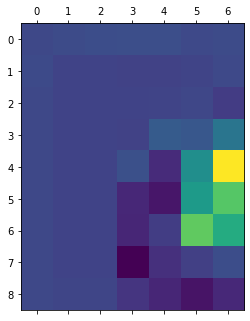

In [32]:
plt.matshow(heatmap)
plt.show()

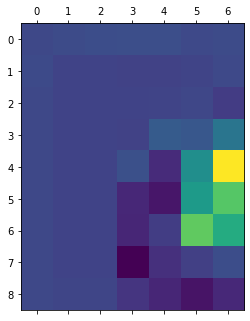

In [33]:
plt.matshow(heatmap)
plt.show()

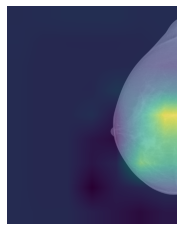

In [34]:
plt.figure()
plt.imshow(im, cmap="Greys_r")
plt.imshow(heatmap1, alpha=0.6)
plt.axis("off")
plt.show()

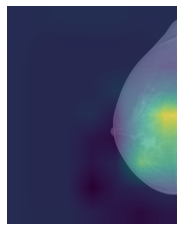

In [35]:
plt.figure()
plt.imshow(img1)
plt.imshow(heatmap1, alpha=0.6)
plt.axis("off")
plt.show()

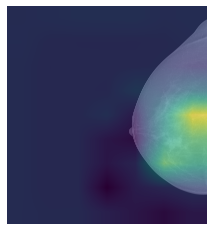

In [36]:
plt.figure()
plt.imshow(img0)
plt.imshow(heatmap2, alpha=0.6)
plt.axis("off")
plt.show()

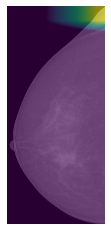

In [37]:
plt.figure()
plt.imshow(img2)
plt.imshow(heatmap3, alpha=0.6)
plt.axis("off")
plt.show()

In [28]:
print(np.shape(im))
print(np.shape(img3))
print(np.shape(img1))
print(np.shape(img2))
print(np.shape(img0))
print(np.shape(heatmap2))
print(np.shape(heatmap3))

(1152, 896)
(1152, 896)
(1152, 896, 3)
(4343, 1970, 3)
(5355, 4915, 3)
(5355, 4915)
(4292, 1920)


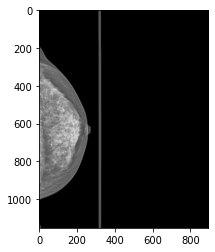

In [23]:
plt.imshow(im, cmap="Greys_r")

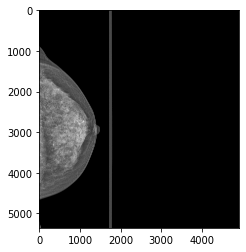

In [34]:
plt.imshow(img3, cmap='gray')

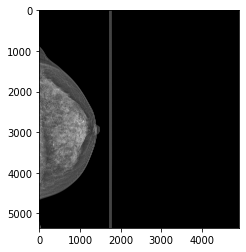

In [21]:
plt.imshow(img1)

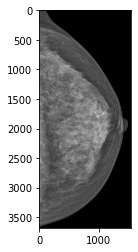

In [22]:
plt.imshow(img2)

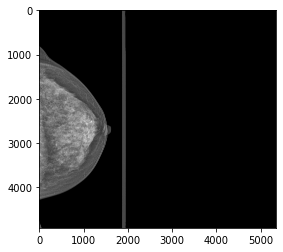

In [ ]:
heatmap2 = cv2.resize(heatmap.numpy(), (896, 1152))

In [8]:
heatmap = heatmap.numpy()
# interpolate the heatmap
img = cv2.imread('sample_output/cropped_images/1ca_1_L_MLO.png')
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('outputs/1ca_1_L_MLO_CAM.jpg', superimposed_img)

True

In [9]:
np.max(heatmap)

255

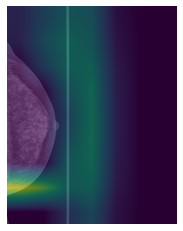

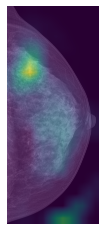

In [12]:
plt.figure()
a = cv2.resize(heatmap1, (896, 1152))

#b = cv2.flip(a, 1)
#c = cv2.flip(im, 1)

b = cv2.resize(a, (1550, 3681))
c = cv2.resize(im, (1550, 3681))

plt.imshow(c, cmap="Greys_r")
plt.imshow(b, alpha=0.6)
plt.axis("off")
plt.show()

In [13]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1152, 896, 3)]    0         
                                                                 
 model_1 (Functional)        (None, None, None, 512)   14714688  
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 28, 512)       2359808   
                                                                 
 batch_normalization_1 (Batc  (None, 36, 28, 512)      2048      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 36, 28, 512)       0         
                                                                 
 dropout_1 (Dropout)         (None, 36, 28, 512)       0         
                                                           